In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box
from api import get_data
import json

from sklearn.cluster import DBSCAN
import geodatasets
import contextily as cx
import community

from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx
import random
import math


'''fips_df = pd.read_csv("state_and_county_fips_master.csv")
fips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]
fips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])
dc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]
md_counties = ["Prince George's County", "Montgomery County"]
va_counties = ["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city"]
md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(md_counties)]["code"] # , "Anne Arundel County", "Howard County", "Baltimore County", "Baltimore city"
va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(va_counties)]["code"] # , "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'fips_df = pd.read_csv("state_and_county_fips_master.csv")\nfips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]\nfips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])\ndc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]\nmd_counties = ["Prince George\'s County", "Montgomery County"]\nva_counties = ["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city"]\nmd_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(md_counties)]["code"] # , "Anne Arundel County", "Howard County", "Baltimore County", "Baltimore city"\nva_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(va_counties)]["code"] # , "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"'

In [2]:
dcs_df = gpd.GeoDataFrame.from_file("data/real_transit/DC_Streetcar_Routes.shp").to_crs("EPSG:4326")
dcs_df.color = 'brown'
marc_df = gpd.GeoDataFrame.from_file("data/real_transit/Maryland_Transit_-_MARC_Train_Lines.shp").to_crs("EPSG:4326")
marc_df["color"] = marc_df["Rail_Name"].apply(lambda a: '#EFAD1D' if 'Brunswick' in a else '#F15828' if 'Camden' in a else '#C71F3E')
wmata_df = gpd.GeoDataFrame.from_file("data/real_transit/Metro_Lines_Regional.shp").to_crs("EPSG:4326")
wmata_df["color"] = wmata_df["NAME"].apply(lambda a: 
    '#F9921D' if 'orange' in a else 
    '#A1A3A1' if 'silver' in a else 
    '#E41838' if 'red' in a else
    '#FED201' if 'yellow' in a else
    '#01A850' if 'green' in a else
   '#0077C1')
vre_df = gpd.GeoDataFrame.from_file("data/real_transit/Virginia_Railway_Express_Routes.shp").to_crs("EPSG:4326")
vre_df["color"] = vre_df["RAILWAY_NM"].apply(lambda a: 
    '#156DB4' if 'Manassas' in a else 
    '#DD3534')
pl_df = gpd.GeoDataFrame.from_file("data/real_transit/PurpleLineAlignment.shp").to_crs("EPSG:4326")
pl_df["color"] = "#793390"

In [48]:
def get_points(df, extremities, layers=8):
    ids = []
    if layers <= 0:
        return ids
    if df.shape[0] < 2:
        return ids
    df_sorted = df.sort_values("point_likelihood",ascending=False)
    top_point = df_sorted.iloc[1]
    ids.append(top_point.SID)
    ex_bl = [extremities[0], extremities[1], top_point["INTPTLON20"], top_point["INTPTLAT20"]]
    df_bl = df.iloc[df.sindex.query(box(*ex_bl))] # bottom left
    ex_br = [top_point["INTPTLON20"], extremities[1], extremities[2], top_point["INTPTLAT20"]]
    df_br = df.iloc[df.sindex.query(box(*ex_br))] # bottom right
    ex_tl = [extremities[0], top_point["INTPTLAT20"], top_point["INTPTLON20"], extremities[3]]
    df_tl = df.iloc[df.sindex.query(box(*ex_tl))] # top left
    ex_tr = [top_point["INTPTLON20"], top_point["INTPTLAT20"], extremities[2], extremities[3]]
    df_tr = df.iloc[df.sindex.query(box(*ex_tr))] # top right
    ids += get_points(df_bl, ex_bl, layers-1) + get_points(df_br, ex_br, layers-1) + get_points(df_tl, ex_tl, layers-1) + get_points(df_tr, ex_tr, layers-1)
    return ids
def contract_louvain_communities_with_positions(G, pos, resolution=1.0):
    # Detect communities using Louvain method with adjustable resolution
    partition = community.best_partition(G, resolution=resolution)

    # Group nodes by community
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    # Compute new positions as the centroid of each community
    new_positions = {}
    for comm, nodes in community_nodes.items():
        x_vals = [pos[n][0] for n in nodes]
        y_vals = [pos[n][1] for n in nodes]
        new_positions[f"Community_{comm}"] = (np.mean(x_vals), np.mean(y_vals))

    # Contract the communities
    contracted_G = nx.Graph()
    for comm in community_nodes:
        contracted_G.add_node(f"Community_{comm}")

    for u, v in G.edges():
        u_comm = f"Community_{partition[u]}"
        v_comm = f"Community_{partition[v]}"
        if u_comm != v_comm:
            contracted_G.add_edge(u_comm, v_comm)

    return contracted_G, new_positions

def angle_between(v1, v2):
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    return math.degrees(math.acos(max(min(cos_angle, 1), -1)))

def reduce_degree(graph, pos, max_degree=4, angle_threshold=10):
    for node in list(graph.nodes()):
        while graph.degree(node) > max_degree:
            def compute_angles():
                neighbors = list(graph.neighbors(node))
                angles = []
                for i in range(len(neighbors)):
                    for j in range(i + 1, len(neighbors)):
                        v1 = (pos[neighbors[i]][0] - pos[node][0], pos[neighbors[i]][1] - pos[node][1])
                        v2 = (pos[neighbors[j]][0] - pos[node][0], pos[neighbors[j]][1] - pos[node][1])
                        angle = angle_between(v1, v2)
                        angles.append((angle, neighbors[i], neighbors[j]))
                return [a for a in angles if a[0] < angle_threshold]

            # Continuously remove edges with small angles, updating after each removal
            angles = compute_angles()
            angles.sort()

            while angles:
                _, n1, n2 = angles.pop(0)

                if graph.has_edge(node, n1) and graph.has_edge(node, n2):
                    if graph[node][n1]['weight'] > graph[node][n2]['weight']:
                        graph.remove_edge(node, n1)
                    else:
                        graph.remove_edge(node, n2)

                # Recompute angles after each edge removal
                angles = compute_angles()
                angles.sort()

            # Fallback to removing the edge with the largest weight if the degree is still too high
            if graph.degree(node) > max_degree:
                edges_with_weights = [(neighbor, graph[node][neighbor]['weight']) for neighbor in graph.neighbors(node)]
                edges_with_weights.sort(key=lambda x: x[1], reverse=True)
                while graph.degree(node) > max_degree and edges_with_weights:
                    neighbor_to_remove = edges_with_weights.pop(0)[0]
                    graph.remove_edge(node, neighbor_to_remove)

    return graph

def remove_isolated_nodes(graph):
    # Find all isolated nodes (degree 0)
    isolated_nodes = [node for node in graph.nodes() if graph.degree(node) == 0]
    
    # Remove isolated nodes from the graph
    graph.remove_nodes_from(isolated_nodes)
    
    return graph
def haversine(coord1, coord2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude.
    Coordinates should be in (latitude, longitude) format.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # Radius of Earth in kilometers
    R = 6371.0
    
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine calculation
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    return distance

def assign_edge_weights(graph, positions):
    """
    Assign weights to edges in the graph based on the geographic distance
    between connected vertices.
    
    Parameters:
    - graph: A networkx graph object.
    - positions: A dictionary where keys are node names and values are (lat, lon) tuples.
    """
    for u, v in graph.edges():
        if u in positions and v in positions:
            coord1 = positions[u]
            coord2 = positions[v]
            distance = haversine(coord1, coord2)
            graph[u][v]['weight'] = distance

    return graph
def perform_walks(graph, pos, num_walks=5, max_distance=200000):
    traversed_edges = set()
    intersections = {}

    def get_straightest_edge(node, prev_node, visited):
        neighbors = [n for n in graph.neighbors(node) if (node, n) not in traversed_edges and (n, node) not in traversed_edges and n not in visited]
        if not neighbors:
            return None

        if prev_node is None:
            return random.choice(neighbors)

        v1 = (pos[node][0] - pos[prev_node][0], pos[node][1] - pos[prev_node][1])

        def angle_to_prev(n):
            v2 = (pos[n][0] - pos[node][0], pos[n][1] - pos[node][1])
            return abs(angle_between(v1, v2))

        return min(neighbors, key=angle_to_prev)

    walks = []

    for _ in range(num_walks):
        start_node = random.choice(list(graph.nodes()))
        walk = [start_node]
        prev_node = None
        current_distance = 0

        while current_distance < max_distance:
            next_node = get_straightest_edge(walk[-1], prev_node, set(walk))

            if next_node is None:
                break

            edge = (walk[-1], next_node)

            # Check for intersection
            if edge in traversed_edges or (edge[1], edge[0]) in traversed_edges:
                if intersections.get(edge, 0) >= 1:
                    break
                intersections[edge] = intersections.get(edge, 0) + 1

            traversed_edges.add(edge)
            walk.append(next_node)
            prev_node = walk[-2]

            current_distance += graph[walk[-2]][walk[-1]]['weight']

        walks.append(walk)

    return walks
def plot_walks(graph, pos, walks, ax):

    # Draw the walks
    def random_hex_color():
        return "#" + ''.join(random.choices('0123456789ABCDEF', k=6))

    for i, walk in enumerate(walks):
        walk_edges = [(walk[j], walk[j + 1]) for j in range(len(walk) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=walk_edges, edge_color=random_hex_color(), width=2, ax=ax)
    return ax

In [4]:
'''md_df = gpd.read_file("data/md/tl_2023_24_tabblock20.shp")
md_df = md_df[md_df["COUNTYFP20"].isin(md_codes.to_list())]
va_df = gpd.read_file("data/va/tl_2023_51_tabblock20.shp")
va_df = va_df[va_df["COUNTYFP20"].isin(va_codes.to_list())]
'''
dc_df = gpd.read_file("data/dc/tl_2023_11_tabblock20.shp")
'''
df = pd.concat([md_df, va_df, dc_df])
df.index = np.arange(df.shape[0])
df = gpd.GeoDataFrame(df)'''

'\ndf = pd.concat([md_df, va_df, dc_df])\ndf.index = np.arange(df.shape[0])\ndf = gpd.GeoDataFrame(df)'

In [10]:
'''
df.to_crs("EPSG:4326",inplace=True)
df["SID"] = df.index
df["INTPTLON20"] = df["INTPTLON20"].apply(lambda a: float(a))
df["INTPTLAT20"] = df["INTPTLAT20"].apply(lambda a: float(a))
# add NEIGHBORS column
df["NEIGHBORS"] = None
df["transit_potential"] = np.log(df['POP20']/(df['ALAND20'] + df['AWATER20'])*1000 + 1)
df.to_file("data/complete_region_df.geojson", driver="GeoJSON")'''

df = gpd.GeoDataFrame.from_file("data/complete_region_df.geojson")
extremities = [df["INTPTLON20"].min(), df["INTPTLAT20"].min(), df["INTPTLON20"].max(), df["INTPTLAT20"].max()]
extremities_dc = [dc_df["INTPTLON20"].min(), dc_df["INTPTLAT20"].min(), dc_df["INTPTLON20"].max(), dc_df["INTPTLAT20"].max()]
df_map = df.to_crs(epsg=3857)
ex_map = [df_map.centroid.x.min(),df_map.centroid.y.min(),df_map.centroid.x.max(),df_map.centroid.y.max()]
df_map_dc = dc_df.to_crs(epsg=3857)
ex_map_dc = [df_map_dc.centroid.x.min(),df_map_dc.centroid.y.min(),df_map_dc.centroid.x.max(),df_map_dc.centroid.y.max()]

In [11]:
#df["point_likelihood"] = df["transit_potential"]
#l = list(set(get_points(df, extremities)))
#points = gpd.GeoDataFrame(df[df['SID'].isin(l)])
#points.to_file("data/graph_points.geojson", driver="GeoJSON")
points = gpd.GeoDataFrame.from_file("data/graph_points.geojson")
combined_df_dc = gpd.GeoDataFrame.from_file("data/dc/non-population-points/combined_df.geojson")
combined_df_dc.reset_index(inplace=True, drop=True)
combined_df_md = gpd.GeoDataFrame.from_file("data/md/non-population-points/combined_df.geojson")
combined_df_md.reset_index(inplace=True, drop=True)
points = pd.concat([points, combined_df_dc, combined_df_md])
points.reset_index(inplace=True)
points = points["geometry"]
df_points = gpd.GeoDataFrame(geometry=points.centroid)
df_points = df_points.drop_duplicates()
df_points.reset_index(inplace=True, drop=True)
df_points.shape

C:\Users\srjnk\AppData\Local\Temp\ipykernel_9328\438316215.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points = gpd.GeoDataFrame(geometry=points.centroid)


(5172, 1)

In [ ]:
pts_array = np.array(list(zip(df_points.to_crs(epsg=3857).geometry.x, df_points.to_crs(epsg=3857).geometry.y)))
gabriel = weights.Gabriel.from_dataframe(df_points, use_index=True,silence_warnings=True)
gabriel_contracted, new_positions = contract_louvain_communities_with_positions(
    gabriel.to_networkx(), 
    {n: pts_array[n] for n in gabriel.to_networkx().nodes()}, 
    5
)
assign_edge_weights(gabriel_contracted, new_positions)
mst_contracted = remove_isolated_nodes(reduce_degree(gabriel_contracted, new_positions, 4, 30))#nx.algorithms.tree.mst.minimum_spanning_tree(gabriel_contracted)
#coordinates = np.column_stack((df_points.to_crs(epsg=3857).geometry.x, df_points.to_crs(epsg=3857).geometry.y))
#positions = dict(zip(mst.nodes, coordinates))

c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\libpysal\weights\gabriel.py:145: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  return cls(point_array, ids=ids, **kwargs)


In [95]:
lines = perform_walks(mst_contracted, new_positions, num_walks=12, max_distance=200000)

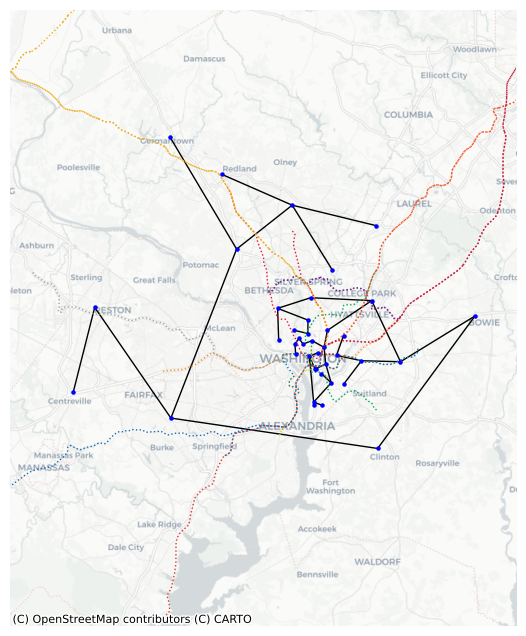

In [96]:
#ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
ax = wmata_df.to_crs(epsg=3857).plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
ax = pl_df.to_crs(epsg=3857).plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
ax = marc_df.to_crs(epsg=3857).plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
ax = vre_df.to_crs(epsg=3857).plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
ax = dcs_df.to_crs(epsg=3857).plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
#f,ax = mst.plot(df.to_crs(epsg=3857), ax=ax,
#        edge_kws=dict(color='r', linewidth=1.2),
#        node_kws=dict(marker=''))
ax.set_xlim([ex_map[0],ex_map[2]])
ax.set_ylim([ex_map[1],ex_map[3]])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax = nx.draw(mst_contracted, new_positions, ax=ax, node_size=5, node_color="b", edge_color="black")
#ax = plot_walks(mst_contracted, new_positions, lines, ax)
#ax = df_points.plot(ax=ax, color='black', marker='*', zorder=100)
plt.savefig("network_map_mst")

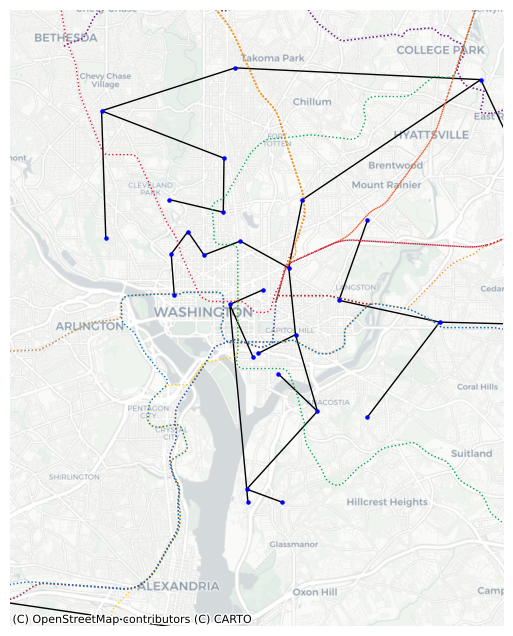

In [97]:
ax = wmata_df.to_crs(epsg=3857).plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
ax = pl_df.to_crs(epsg=3857).plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
ax = marc_df.to_crs(epsg=3857).plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
ax = vre_df.to_crs(epsg=3857).plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
ax = dcs_df.to_crs(epsg=3857).plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
#f,ax = mst.plot(df.to_crs(epsg=3857), ax=ax,
#        edge_kws=dict(color='r', linewidth=1.2),
#        node_kws=dict(marker=''))
#ax = df_points.to_crs(epsg=3857).plot(ax=ax, color='black', marker='*', zorder=100)
ax.set_xlim([ex_map_dc[0],ex_map_dc[2]])
ax.set_ylim([ex_map_dc[1],ex_map_dc[3]])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax = nx.draw(mst_contracted, new_positions, ax=ax, node_size=5, node_color="b", edge_color="black")
#ax = plot_walks(mst_contracted, new_positions, lines, ax)
plt.savefig("network_map_dc_mst")

In [32]:
'''url_prefix = "https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/"
url_suffix = "" + url_suffix
url = url_prefix + "Health_WebMercator/MapServer/4" + url_suffix
hospital_df = get_data(url, 'hospital')
url = url_prefix + "Business_Goods_and_Service_WebMercator/MapServer/4" + url_suffix
grocery_df = get_data(url, 'grocery')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/5" + url_suffix
religion_df = get_data(url, 'religion')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/4" + url_suffix
library_df = get_data(url, 'library')
url = url_prefix + "Location_WebMercator/FeatureServer/3" + url_suffix
poi_df = get_data(url, 'poi')
url = url_prefix + "Education_WebMercator/MapServer/5" + url_suffix
pub_school_df = get_data(url, 'pub_school')
url = url_prefix + "Education_WebMercator/MapServer/3" + url_suffix
ind_school_df = get_data(url, 'ind_school')
url = url_prefix + "Recreation_WebMercator/MapServer/3" + url_suffix
rec_df = get_data(url, 'rec')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/54" + url_suffix
museum_df = get_data(url, 'museum')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/6" + url_suffix
unknown_df = get_data(url, 'unknown')
url = url_prefix + "Health_WebMercator/MapServer/7" + url_suffix
primary_care_df = get_data(url, 'primary_care')
url = url_prefix + "Public_Service_WebMercator/MapServer/55" + url_suffix
wic_df = get_data(url, 'wic')
url = url_prefix + "Business_Goods_and_Service_WebMercator/MapServer/9" + url_suffix
pharm_df = get_data(url, 'pharm')'''
url_prefix = "https://geodata.md.gov/imap/rest/services/"
url_suffix = "/query?where=1%3D1&outFields=*&outSR=4326&f=json"
url = url_prefix + "Structure/MD_StateFacilities/FeatureServer/0" + url_suffix
state_facilities_df = get_data(url, 'state_facilities', 'md')
url = url_prefix + "Military/MD_MilitaryInstallations/FeatureServer/0" + url_suffix
fed_mil_df = get_data(url, 'fed_mil', 'md')
url = url_prefix + "Military/MD_MilitaryInstallations/FeatureServer/1" + url_suffix
state_mil_df = get_data(url, 'state_mil', 'md')
url = url_prefix + "Structure/MD_CommunitySupport/FeatureServer/0" + url_suffix
gov_support_df = get_data(url, 'gov_support', 'md')
url = url_prefix + "BusinessEconomy/MD_IncentiveZones/FeatureServer/11" + url_suffix
incentive_zones_df = get_data(url, 'incentive_zones', 'md')
url = url_prefix + "BusinessEconomy/MD_IncentiveZones/FeatureServer/1" + url_suffix
main_street_df = get_data(url, 'main_street', 'md')
url = url_prefix + "Education/MD_Libraries/FeatureServer/0" + url_suffix
libraries_df = get_data(url, 'libraries', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/2" + url_suffix
fy_priv_df = get_data(url, 'fy_priv', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/5" + url_suffix
k12_public_df = get_data(url, 'k12_public', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/6" + url_suffix
k12_charter_df = get_data(url, 'k12_charter', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/4" + url_suffix
higher_ed_df = get_data(url, 'higher_ed', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/1" + url_suffix
ty_public_df = get_data(url, 'ty_public', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/0" + url_suffix
fy_public_df = get_data(url, 'fy_public', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/3" + url_suffix
ty_private_df = get_data(url, 'ty_private', 'md')
url = url_prefix + "Health/MD_LongTermCareAssistedLiving/FeatureServer/1" + url_suffix
assisted_df = get_data(url, 'assisted', 'md')
url = url_prefix + "Health/MD_Hospitals/FeatureServer/0" + url_suffix
hospital_df = get_data(url, 'hospital', 'md')
url = url_prefix + "Historic/MD_NationalRegisterHistoricPlaces/FeatureServer/0" + url_suffix
nrhp_df = get_data(url, 'nrhp', 'md')
url = url_prefix + "BusinessEconomy/MD_IncentiveZones/FeatureServer/12" + url_suffix
arts_df = get_data(url, 'arts', 'md')

In [ ]:
arts_df["attributes"].apply(lambda a: a['county'])

0            Worcester
1           Montgomery
2           Dorchester
3         Anne Arundel
4             Allegany
5            Frederick
6                Cecil
7      Prince George's
8           Washington
9              Harford
10      Baltimore City
11            Allegany
12            Wicomico
13          Montgomery
14           Worcester
15      Baltimore City
16          Montgomery
17             Harford
18      Baltimore City
19        Queen Anne's
20          St. Mary's
21                Kent
22             Garrett
23             Garrett
24            Caroline
25            Somerset
26              Talbot
27      Baltimore City
28    Baltimore County
Name: attributes, dtype: object

In [113]:
'''combined_df = pd.concat([hospital_df, grocery_df, religion_df, library_df, poi_df, pub_school_df, ind_school_df, rec_df, museum_df, unknown_df, primary_care_df, wic_df, pharm_df])
combined_df.reset_index(inplace=True, drop=True)
combined_df.to_file("data/dc/non-population-points/combined_df.geojson", driver="GeoJSON")'''
import re
combined_df = pd.concat([state_facilities_df, fed_mil_df, state_mil_df, gov_support_df, incentive_zones_df, main_street_df, libraries_df, fy_priv_df, k12_public_df, k12_charter_df, higher_ed_df, ty_public_df, fy_public_df, ty_private_df, assisted_df, hospital_df, nrhp_df])
def converter(a):
    if type(a) == dict:
        if 'county' in a:
            return a['county'].strip().lower()
        elif "County" in a:
            return a['County'].strip().lower()
        else:
            return 'baltimore city'
    else:
        try:
            return converter(dict(a))
        except:
            try:
                return converter(json.loads(a))
            except:
                matches = re.finditer(r'county[\'"] ?:', a.lower())
                for match in matches:
                    search_area = a.lower()[match.end():match.end()+50].strip()
                    m = re.findall(r'[\'"]([a-z \']+)[\'"]', search_area)
                    if m and m[0]:
                        return m[0]
                return 'UNK'
combined_df["county"] = combined_df["attributes"].apply(converter)
combined_df = combined_df[combined_df["county"].apply(lambda a: 'george' in a or 'montgom' in a)]
combined_df.reset_index(inplace=True, drop=True)
combined_df.to_file("data/md/non-population-points/combined_df.geojson", driver="GeoJSON")
combined_df = gpd.GeoDataFrame.from_file("data/dc/non-population-points/combined_df.geojson")
combined_df

,attributes,geometry
0,{'NAME': 'MedStar National Rehabilitation Hosp...,POINT (-77.01335 38.93055)
1,"{'NAME': ""Children's National Medical Center (...",POINT (-77.0144 38.92727)
2,"{'NAME': 'United Medical Center (Acute Care)',...",POINT (-76.98475 38.83603)
3,{'NAME': 'BridgePoint Hospital Capitol Hill (L...,POINT (-76.99583 38.89308)
4,{'NAME': 'Howard University Hospital (Acute Ca...,POINT (-77.0201 38.91756)
...,...,...
3732,"{'NAME': 'MORTON 8TH ST. PHARMACY', 'LICENSE_N...",POINT (-76.99518 38.89006)
3733,"{'NAME': 'GOODCARE PHARMACY', 'LICENSE_NUMBER'...",POINT (-76.99657 38.8457)
3734,"{'NAME': ""GRUBB'S PHARMACY SE INC"", 'LICENSE_N...",POINT (-76.98806 38.86758)
3735,"{'NAME': 'HARRIS TEETER #352', 'LICENSE_NUMBER...",POINT (-77.00561 38.90594)
